## TF-IDF (k-mer based)

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import re
import utils
import os, errno
from IPython.display import display
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<div>
  <input type="button" value="Show/Hide Code" onclick="code_toggle()" style="display: block; margin: 0 auto;">
</div>''')

### Load Data

In [60]:
non_zoonotic = utils.loadFASTA("./content/NonZoonoticVirusesStringent0_0_GlobalViromeProject.fasta")
is_zoonotic = utils.loadFASTA("./content/ZoonoticVirusSequencesStringentGlobalViromeProject.fasta")
non_zoonotic['Label'] = [0]*len(non_zoonotic)
is_zoonotic['Label'] = [1]*len(is_zoonotic)

# Join the two sets
data = pd.concat([non_zoonotic,is_zoonotic]).reset_index(drop=True)
#display(data.head())
#display(data.tail())

# Remove ambiguous nucleotides (https://reverse-complement.com/ambiguity.html)
# - as per Kameris method
data['Sequence'] = data['Sequence'].apply(utils.strip_ambiguous_nucleotides)

# Check for any null values
#print("Nulls:")
#print(data.isnull().sum())
#print(data.applymap(lambda x: x == '').sum())

X_raw = data["Sequence"]
y = data["Label"]

### Extract TF-IDF Features
k = 3 gives best results, as with Kameris

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

def kmer_tokeniser(seq, k=3, overlap=True):
    """Simply tokenises a DNA/RNA sequences by splitting it into groups of k.
    """
    n = len(seq)
    if overlap:
        # Calculate overlapping k-mers.
        # e.g. AACGTA -> AAC, ACG, CGT, GTA
        tokens = []
        for i in range(n):
            if (i+k) <= n:
                subseq = seq[i:i+k]
            else:
                # wrap around -> no assumption of alignment
                subseq = seq[i:n]+seq[:i+k-n]
            tokens.append(subseq)
    else:
        # Calculate non-overlapping k-mers
        # e.g. AACGTA -> AAC, GTA
        tokens = [seq[i:i+k] for i in range(0, len(seq), k)]
        if len(tokens[-1]) < k:
            tokens.remove(tokens[-1])
    return tokens
vectorizer = TfidfVectorizer(tokenizer=kmer_tokeniser)
X = vectorizer.fit_transform(X_raw).todense()
print(vectorizer.get_feature_names())
print(X.shape)

['aaa', 'aac', 'aag', 'aat', 'aca', 'acc', 'acg', 'act', 'aga', 'agc', 'agg', 'agt', 'ata', 'atc', 'atg', 'att', 'caa', 'cac', 'cag', 'cat', 'cca', 'ccc', 'ccg', 'cct', 'cga', 'cgc', 'cgg', 'cgt', 'cta', 'ctc', 'ctg', 'ctt', 'gaa', 'gac', 'gag', 'gat', 'gca', 'gcc', 'gcg', 'gct', 'gga', 'ggc', 'ggg', 'ggt', 'gta', 'gtc', 'gtg', 'gtt', 'taa', 'tac', 'tag', 'tat', 'tca', 'tcc', 'tcg', 'tct', 'tga', 'tgc', 'tgg', 'tgt', 'tta', 'ttc', 'ttg', 'ttt']
(201, 64)


### Visualise Feature Space
The classes do not appear separable...

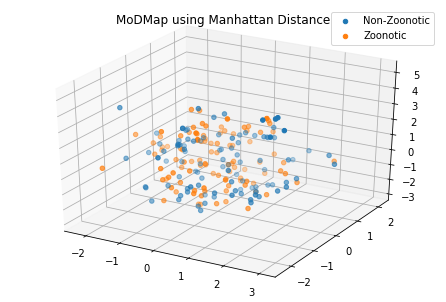

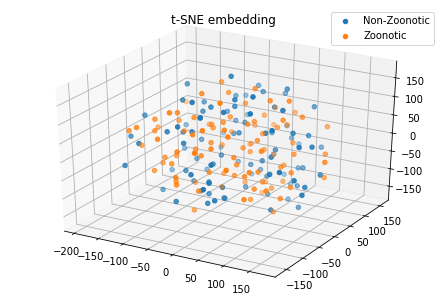

In [74]:
# Visualise data (again)
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold

# MultiDimensional Scaling (MDS) with Manhattan pairwise distances (as per Kameris)
D = pairwise_distances(np.array(X), metric="manhattan", n_jobs=3)
embedding = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
vizData = embedding.fit_transform(D)

# Plot
fig = plt.figure()
ax = Axes3D(fig)
vizDataNonZoo = vizData[y==0,:]
vizDataZoo = vizData[y==1, :]
ax.scatter(vizDataNonZoo[:,0],vizDataNonZoo[:,1],vizDataNonZoo[:,2], label="Non-Zoonotic")
ax.scatter(vizDataZoo[:,0],vizDataZoo[:,1],vizDataZoo[:,2], label="Zoonotic")
ax.legend()
ax.set_title("MoDMap using Manhattan Distance")
plt.show();

# t-SNE embedding
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
vizData = tsne.fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
vizDataNonZoo = vizData[y==0,:]
vizDataZoo = vizData[y==1, :]
ax.scatter(vizDataNonZoo[:,0],vizDataNonZoo[:,1],vizDataNonZoo[:,2], label="Non-Zoonotic")
ax.scatter(vizDataZoo[:,0],vizDataZoo[:,1],vizDataZoo[:,2], label="Zoonotic")
ax.legend()
ax.set_title("t-SNE embedding")
plt.show();

### Test Accuracy - 68%
This is slightly better than Kameris (and much better than Castor)

In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import numpy as np
import skopt
 
# ignore deprecation warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    test_acc = 0
    rep = 1
    test_accs = []
    f_scores = []
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    X, y = np.array(X), np.array(y)
    for train_index, test_index in skf.split(X,y):
      X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    #for i in range(rep):
      #X, y = shuffle(X, y)
#       X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2) 
#       clf = SVC(kernel="linear", C=1)
      clf = XGBClassifier(max_depth=64, min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0)#, n_estimators=50)#, learning_rate=0.1, n_estimators=100)
      clf.fit(X_train, y_train)
      pred = clf.predict(X_train)
      accuracy = (y_train==pred).sum() / len(y_train)

      pred = clf.predict(X_test)
      accuracy = (y_test==pred).sum() / len(y_test)
      test_accs.append(accuracy)
      f = f1_score(y_test, pred, average='macro')
      f_scores.append(f)
    test_accs = np.array(test_accs)
    f_scores = np.array(f_scores)
    print("Stratified K-Fold Split")
    print("Test Accuracy: %.4f +/- %.4f"%(test_accs.mean(),test_accs.std()))
    print("Min: %.4f, Max: %.4f"%(test_accs.min(),test_accs.max()))
    print("\nF1 Score: %.4f +/- %.4f"%(f_scores.mean(),f_scores.std()))
    print("Min: %.4f, Max: %.4f"%(f_scores.min(),f_scores.max()))

Stratified K-Fold Split
Test Accuracy: 0.6809 +/- 0.1335
Min: 0.5000, Max: 0.9000

F1 Score: 0.6739 +/- 0.1388
Min: 0.4505, Max: 0.8990
